In [1]:
import uproot
import h5py    
import numpy as np
import awkward as ak
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from scipy.stats import moyal, norm
from scipy import optimize
from collections import defaultdict

In [2]:
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

In [13]:
dic = defaultdict(list)
for jet_number in range(4, 9):
    file = uproot.open("top-{}jets-output.root".format(jet_number))
    max_index = np.argmax(np.stack(file['KLFitter_output']['klf_loglikelihood'].arrays(library="np")['klf_loglikelihood']), axis=1, keepdims=True)
    for target in ['klf_lquark1_pt', 'klf_lquark1_eta', 'klf_lquark1_phi', 'klf_lquark1_e',
                   'klf_lquark2_pt', 'klf_lquark2_eta', 'klf_lquark2_phi', 'klf_lquark2_e', 'klf_param8', 'klf_bhad_pt', 'klf_blep_pt']:
        arr = np.stack(file['KLFitter_output'][target].arrays(library="np")[target])
        arr = np.take_along_axis(arr, max_index, axis=1).flatten()
        dic[target].extend(arr)

for key in dic: dic[key] = np.array(dic[key])

In [18]:
# px = pt*cos(phi)
# py = pt*sin(phi)
# pz = pt*sinh(eta)
dic['px1'] = dic['klf_lquark1_pt']*np.cos(dic['klf_lquark1_phi'])
dic['py1'] = dic['klf_lquark1_pt']*np.sin(dic['klf_lquark1_phi'])
dic['pz1'] = dic['klf_lquark1_pt']*np.sinh(dic['klf_lquark1_eta'])

dic['px2'] = dic['klf_lquark2_pt']*np.cos(dic['klf_lquark2_phi'])
dic['py2'] = dic['klf_lquark2_pt']*np.sin(dic['klf_lquark2_phi'])
dic['pz2'] = dic['klf_lquark2_pt']*np.sinh(dic['klf_lquark2_eta'])

# M = sqrt((E1+E2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2)
dic['reconstructed_W_mass'] = np.sqrt((dic['klf_lquark1_e']+dic['klf_lquark2_e'])**2
                 - (dic['px1']+dic['px2'])**2
                 - (dic['py1']+dic['py2'])**2
                 - (dic['pz1']+dic['pz2'])**2)


"""
For events with two or more b-tagged jets, R reco bq is defined as the scalar sum of the transverse momenta of the b-tagged jets assigned
to the leptonically and hadronically decaying top quarks divided by the scalar sum of the transverse
momenta of the two jets associated with the hadronic W boson decay.
"""

dic['reconstructed_R_bq'] = (dic['klf_bhad_pt'] + dic['klf_blep_pt'])/(dic['klf_lquark1_pt'] + dic['klf_lquark2_pt'])

In [48]:
"""
130 < reco_m_top < 220
55 < reco_m_W < 110
0.3 < reco_R_bq < 3.0
"""

cut1 = np.logical_and(dic['klf_param8'] < 220, dic['klf_param8'] > 130)
cut2 = np.logical_and(dic['reconstructed_W_mass'] < 110, dic['reconstructed_W_mass'] > 55)
cut3 = np.logical_and(dic['reconstructed_R_bq'] < 3.0, dic['reconstructed_R_bq'] > 0.3)
cuts = np.logical_and(np.logical_and(cut1, cut2), cut3)

In [49]:
print('Events before cut: ', len(dic['klf_param8']))
print('reco_m_top cut: ', np.count_nonzero(cut1))
print('reco_m_W cut: ', np.count_nonzero(cut2))
print('reco_R_bq cut: ', np.count_nonzero(cut3))
print('cuts', np.count_nonzero(cuts))

Events before cut:  643622
reco_m_top cut:  430124
reco_m_W cut:  557831
reco_R_bq cut:  620164
cuts 404087


In [50]:
for key in dic: dic[key] = dic[key][cuts]

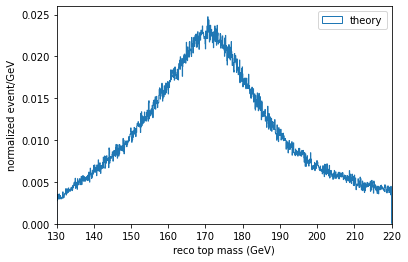

In [53]:
arr = sorted(dic['klf_param8'])
plt.hist(dic['klf_param8'],bins=1000, density=True, histtype='step', label='theory')
plt.xlim(130, 220)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('normalized event/GeV')
plt.legend()
plt.show()

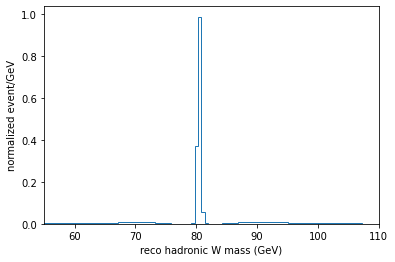

In [54]:
plt.hist(dic['reconstructed_W_mass'], bins=100, density=True, histtype='step')
plt.xlim(55, 110)
plt.xlabel('reco hadronic W mass (GeV)')
plt.ylabel('normalized event/GeV')
plt.show()

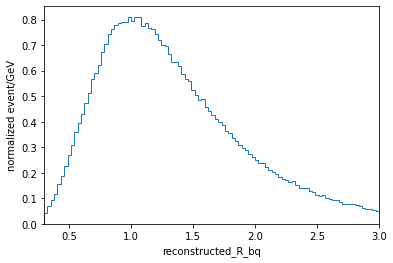

In [55]:
plt.hist(dic['reconstructed_R_bq'], bins=100, density=True, histtype='step')
plt.xlim(0.3, 3.0)
plt.xlabel('reconstructed_R_bq')
plt.ylabel('normalized event/GeV')
plt.show()